In [1]:
import os
import sys
import shutil
import subprocess

In [2]:
sys.path.append('/home/aalvarez/Work/Projects/Elements/5.8/InstallArea/x86_64-fc30-gcc92-dbg/python/')
sys.path.append('/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/InstallArea/x86_64-fc30-gcc92-dbg/python/')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from nnpz.reference_sample.ReferenceSample import ReferenceSample

# Filters and seds
We use only fake, peaky, Y and J bands, and an artifical SED with a very marked peak.

In [4]:
sed = np.asarray([(10000, 0.), (10010, 0.1),(10020,0.)])
sed_shifted = sed.copy()
sed_shifted[:,0] *= 1.3
sed_shifted[:,1] /= 1.3

In [5]:
Y = np.recfromtxt('/home/aalvarez/Work/Data/TestShift/Filters/Y.ascii')
J = np.recfromtxt('/home/aalvarez/Work/Data/TestShift/Filters/J.ascii')

In [6]:
shift = np.average(J[:,0], weights=J[:,1]) - np.average(Y[:,0], weights=Y[:,1])
shift

3000.0

In [7]:
np.average(sed_shifted[:,0], weights=sed_shifted[:,1]) - np.average(sed[:,0], weights=sed[:,1])

3003.0

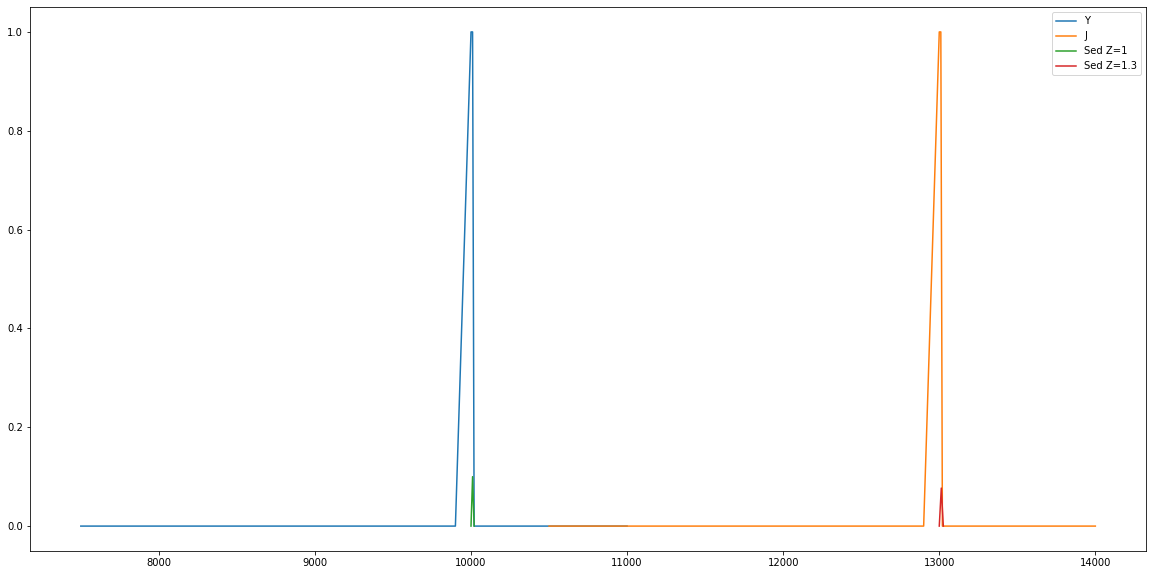

In [8]:
plt.figure(figsize=(20,10))
plt.plot(Y[:,0], Y[:,1], label='Y')
plt.plot(J[:,0], J[:,1], label='J')
plt.plot(sed[:,0], sed[:,1], label='Sed Z=1')
plt.plot(sed_shifted[:,0], sed_shifted[:,1], label='Sed Z=1.3')
plt.legend()

We can see that for a redshift of 1, the SED falls fully into the 'Y' band, while for 1.3 it falls into 'J'.

# Reference sample
We generate only 10, half with an arbitrary redshift of 1, and half with an arbitrary refshift of 1.3

In [9]:
ref_sample_dir = '/home/aalvarez/Work/Data/TestShift/ReferenceSample'
photometry_file = '/home/aalvarez/Work/Data/TestShift/ReferencePhotometry.fits'
shutil.rmtree(ref_sample_dir, ignore_errors=True)
ref_sample = ReferenceSample.createNew(ref_sample_dir)
for i in range(0, 5):
    ref_sample.createObject(i)
    ref_sample.addSedData(i, sed)
    ref_sample.addPdzData(i, np.asarray([(1., 1.), (1.3, 0.)]))
for i in range(5, 10):
    ref_sample.createObject(i)
    ref_sample.addSedData(i, sed_shifted)
    ref_sample.addPdzData(i, np.asarray([(1., 0.), (1.3, 1.)]))

In [10]:
if os.path.exists(photometry_file): os.unlink(photometry_file)
    
import subprocess
subprocess.call([
    '/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/build.x86_64-fc30-gcc92-dbg/run', 'NnpzBuildPhotometry',
    '--sample-dir', ref_sample_dir,
    '--out-type', 'F_nu_uJy',
    '--out-file', photometry_file,
    '--filters', '/home/aalvarez/Work/Data/TestShift/Filters'
])

0

In [11]:
photometry = Table.read(photometry_file, hdu=1)
photometry

ID,J,Y
int64,float32,float32
0,0.0,5.137677e+16
1,0.0,5.137677e+16
2,0.0,5.137677e+16
3,0.0,5.137677e+16
4,0.0,5.137677e+16
5,6.0776566e+16,0.0
6,6.0776566e+16,0.0
7,6.0776566e+16,0.0
8,6.0776566e+16,0.0


* The first four sources, with a redshift of 1, fall entirely in 'Y'.
* The second four sources, with a redshift of 1.3, fall entirely in 'J'

# Catalog
Now we generate just four sources: two with a redshift of 1, two with a redshift of 1.3. For each redshift, one without filter shift, one with.

In [12]:
os.environ['ELEMENTS_AUX_PATH'] = '/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/InstallArea/x86_64-fc30-gcc92-dbg/auxdir/'
from nnpz.photometry.PhotometryCalculator import PhotometryCalculator
from nnpz.photometry.FnuuJyPrePostProcessor import FnuuJyPrePostProcessor
from nnpz.photometry.DirectoryFilterProvider import DirectoryFilterProvider

In [13]:
redshifts = [1., 1.3, 1., 1.3]
filter_shifts = [0., 0., True, True]

In [14]:
filter_provider = DirectoryFilterProvider('/home/aalvarez/Work/Data/TestShift/Filters/')
filter_map = {
    'Y': filter_provider.getFilterTransmission('Y'),
    'J': filter_provider.getFilterTransmission('J'),
}
filter_map_shift = {
    'Y': filter_map['Y'].copy(),
    'J': filter_map['J'].copy()
}
filter_map_shift['Y'][:,0] += shift
filter_map_shift['J'][:,0] -= shift
calculator = PhotometryCalculator(filter_map, FnuuJyPrePostProcessor())
calculator_shifted = PhotometryCalculator(filter_map_shift, FnuuJyPrePostProcessor())

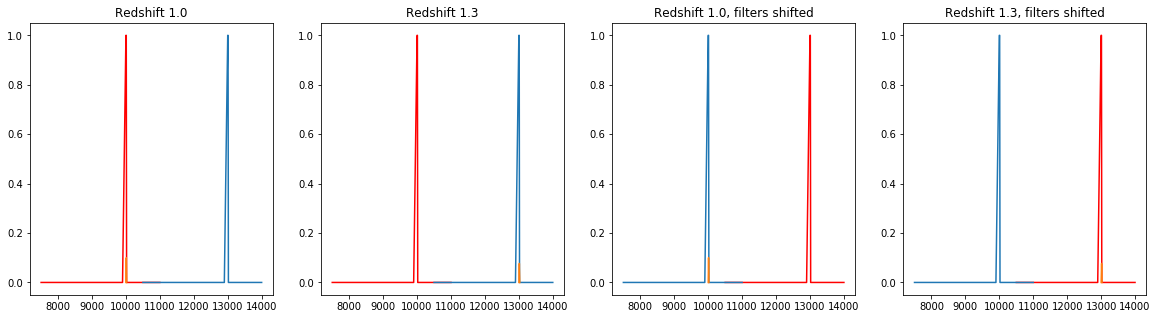

In [15]:
rows = []
fig, axes = plt.subplots(1, 4, figsize=(20,5))
for i, (redshift, filter_shift) in enumerate(zip(redshifts, filter_shifts)):
    redshifted_sed = sed.copy()
    redshifted_sed[:,0]+=1. # Just avoid infinites
    redshifted_sed[:,0]*=redshift
    redshifted_sed[:,1]/=redshift

    title = f'Redshift {redshift}'
    if filter_shift:
        photo = calculator_shifted.compute(redshifted_sed)
        axes[i].plot(Y[:,0]+shift, Y[:,1], label='Y', c='r')
        axes[i].plot(J[:,0]-shift, J[:,1], label='J')
        this_shift = shift
        title += ', filters shifted'
    else:
        photo = calculator.compute(redshifted_sed)
        axes[i].plot(Y[:,0], Y[:,1], label='Y', c='r')
        axes[i].plot(J[:,0], J[:,1], label='J')
        this_shift = 0
    axes[i].set_title(title)
    
    axes[i].plot(redshifted_sed[:,0], redshifted_sed[:,1], label='SED')
    rows.append((i, photo['Y'], photo['J'], redshift, +this_shift, -this_shift))

In [16]:
if os.path.exists('/home/aalvarez/Work/Data/TestShift/Catalog.fits'): os.unlink('/home/aalvarez/Work/Data/TestShift/Catalog.fits')

catalog = Table(rows=rows, names=['ID', 'Y', 'J', 'Z', 'Y_shift', 'J_shift'])
catalog.write('/home/aalvarez/Work/Data/TestShift/Catalog.fits')

In [17]:
catalog

ID,Y,J,Z,Y_shift,J_shift
int64,float64,float64,float64,float64,float64
0,4.62437107219698e+16,0.0,1.0,0.0,0.0
1,0.0,4.949443173420478e+16,1.3,0.0,0.0
2,0.0,4.62437107219698e+16,1.0,3000.0,-3000.0
3,4.949443173420478e+16,0.0,1.3,3000.0,-3000.0


# Run NNPZ without correcting the filter shift

In [18]:
catalog_without_filter_shift = '/home/aalvarez/Work/Data/TestShift/TestRunNo.fits'
if os.path.exists(catalog_without_filter_shift):
    os.unlink(catalog_without_filter_shift)
subprocess.call([
    '/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/build.x86_64-fc30-gcc92-dbg/run', 'nnpz',
    '--config-file', '/home/aalvarez/Work/Data/TestShift/nnpz.conf',
    '--target_catalog_filters_shift=None',
    '--output_file', catalog_without_filter_shift
], cwd='/home/aalvarez/Work/Data/TestShift/')

0

In [19]:
no_correction = Table.read(catalog_without_filter_shift, hdu=1)
no_correction[['ID', 'REDSHIFT_MODE', 'Z']]

ID,REDSHIFT_MODE,Z
int64,float32,float64
0,1.0,1.0
1,1.3,1.3
2,1.3,1.0
3,1.0,1.3


Without corrections, the predictions are obviosly wrong, as the redshift 1.0 with filter shift looks exactly as a redshift 1.3 

# Run NNPZ with correction

In [20]:
catalog_with_filter_shift = '/home/aalvarez/Work/Data/TestShift/TestRun.fits'
if os.path.exists(catalog_with_filter_shift):
    os.unlink(catalog_with_filter_shift)
subprocess.call([
    '/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/build.x86_64-fc30-gcc92-dbg/run', 'nnpz',
    '--config-file', '/home/aalvarez/Work/Data/TestShift/nnpz.conf',
    '--output_file', catalog_with_filter_shift
], cwd='/home/aalvarez/Work/Data/TestShift/')

0

In [21]:
correction = Table.read(catalog_with_filter_shift, hdu=1)
correction[['ID', 'REDSHIFT_MODE', 'Z']]

ID,REDSHIFT_MODE,Z
int64,float32,float64
0,1.0,1.0
1,1.3,1.3
2,1.0,1.0
3,1.3,1.3


Now the values are exactly what expected, since the artificial shift has been corrected.